<a href="https://colab.research.google.com/github/xiaochengJF/MachineLearning/blob/master/Ex5_Bais_VS_Variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/MachineLearning/ex5-bias vs variance

/content/drive/My Drive/MachineLearning/ex5-bias vs variance


# 偏差和方差

In [0]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
def load_data():
    """for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [0]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [0]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot('water_level', 'flow', data=df, fit_reg=False, size=7)
plt.show()

In [0]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

# 代价函数
$$J(\theta)=\frac1{2m}\sum^m_{i=1}\left(h_\theta(x^{(i)})-y^{(i)}\right)^2$$

In [0]:
def cost(theta, X, y):
    """
    X: R(m*n), m records, n features
    y: R(m)
    theta : R(n), linear regression parameters
    """
    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)

    # 1*m @ m*1 = 1*1 in matrix multiplication
    # but you know numpy didn't do transpose in 1d array, so here is just a
    # vector inner product to itselves
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [8]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

# 梯度
$$\theta_j：=\theta_j-\alpha\frac\partial{\partial\theta_j}J(\theta)$$

In [0]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [10]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

# 正则化梯度
$$\begin{aligned}
\frac{\partial J(\theta)}{\partial\theta_0}&=
\frac1{m}\sum^m_{i=1}\left(h_\theta(x^{(i)})-y^{(i)}\right)x_j^{(i)}&\qquad\text{for $j=0$}\\
\frac{\partial J(\theta)}{\partial\theta_j}&=
\left(\frac1{m}\sum^m_{i=1}\left(h_\theta(x^{(i)})-y^{(i)}\right)x_j^{(i)}\right)+\frac\lambda m\theta_j&\qquad\text{for $j\geq1$}
\end{aligned}$$

In [0]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (l / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [12]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

# 拟合数据

<font face=楷体 color=skyblue size=4>正则化项 $\lambda=0$</font>

In [0]:
def linear_regression_np(X, y, l=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res


In [0]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [0]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')

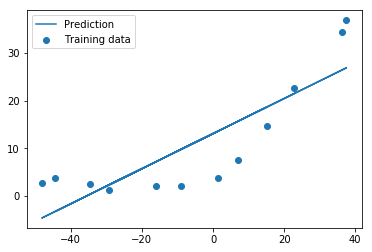

In [16]:
b = final_theta[0]  # intercept
m = final_theta[1]  # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

In [0]:
training_cost, cv_cost = [], []

<font face=楷体>
1.使用训练集的子集来拟合应模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价
</font>

In [0]:
m = X.shape[0]
for i in range(1, m+1):
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

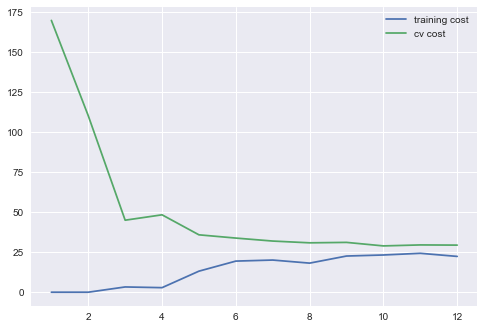

In [0]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

<font face=楷体>从图可知模型欠拟合</font>

# 创建多项式特征

In [0]:
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)

        # normalization
        ndarr = normalize_feature(df).as_matrix() 

        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [0]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df


In [0]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [22]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


# 准备多项式回归数据
<font face=楷体>
    
1. 扩展特征到 8阶,或者你需要的阶数  
2. 使用 **归一化** 来合并 $x^n$   
3. 注意截距项
    
</font>

In [0]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [24]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

# 画出学习曲线  
<font face=楷体 color=skyblue size=4>
先不使用正则化，所以 $\lambda=0$  

</font>  
<font face=楷体 color=yellow size=4>疑问：</font>  
为什么优化时用正则项，计算cost不用正则项

In [0]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # 正则化用于拟合参数
        res = linear_regression_np(X[:i, :], y[:i], l=l)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        # 正则化仅用于拟合参数，cost不包含正则项？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？？
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)

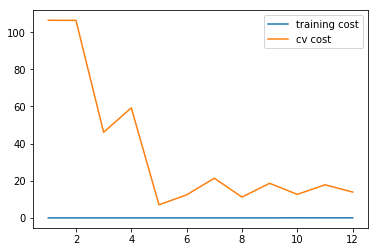

In [26]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

<font face=楷体> training cost为0，明显过拟合</font>

<font face=楷体 color=skyblue size=4>
$\lambda=1$
</font>

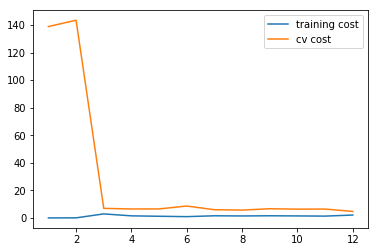

In [28]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

<font face=楷体> 
减轻过拟合
</font>

<font face=楷体 color=skyblue size=4>
$\lambda=100$
</font>

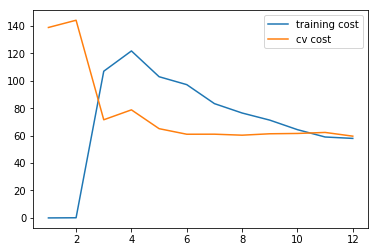

In [29]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

<font face=楷体> 
欠拟合
</font>

<font face=楷体 color=skyblue size=4>
找到最佳的 $\lambda$
</font>

In [0]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [0]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

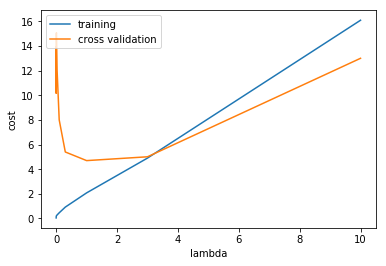

In [32]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [39]:
# 返回最小cv_cost下标，即：挑出验证集上表现最好的lambda
l_candidate[np.argmin(cv_cost)]

1

<font face=楷体> 
验证集上表现最好的是$\lambda=0.001$
</font>

In [34]:
# 使用测试数据来计算成本
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 9.982275423899827
test cost(l=0.001) = 10.96403493885111
test cost(l=0.003) = 11.264458872657682
test cost(l=0.01) = 10.880094765571297
test cost(l=0.03) = 10.022266931655883
test cost(l=0.1) = 8.632063139750382
test cost(l=0.3) = 7.336640278544401
test cost(l=1) = 7.466289435179381
test cost(l=3) = 11.64393193727906
test cost(l=10) = 27.715080291767972


<font face=楷体> 
调参后， $\lambda = 0.3$ 是最优选择，测试代价最小
</font>